In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! scp -r arnab_sen_sharma@compute.safe.ai:/data/arnab_sen_sharma/Projects/relations/results ../../

In [3]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [4]:
############################################
sweep_root = "../../results/sweep/faithfulness"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [5]:
from src.sweeps import (
    SweepFaithfulnessBetaResults,
    SweepFaithfulnessTrainResults,
    SweepFaithfulnessLayerResults,
    SweepFaithfulnessLayerSummary,
    SweepFaithfulnessTrialResults,
    SweepFaithfulnessLayerSummary,
    SweepFaithfulnessRelationResults
)

def parse_results(sweep_result):
    relation_results = SweepFaithfulnessRelationResults(
        relation_name=sweep_result["relation_name"],
        trials = []
    )

    for trial in sweep_result["trials"]:
        trial_results = SweepFaithfulnessTrialResults(
            prompt_template=trial["prompt_template"],
            train_samples=trial["train_samples"],
            layers = []
        )
        for layer in trial["layers"]:
            train_results = SweepFaithfulnessTrainResults(
                samples = layer["result"]["samples"],
                betas = []
            )
            for beta in layer["result"]["betas"]:
                beta_results = SweepFaithfulnessBetaResults(
                    beta = beta["beta"],
                    recall = beta["recall"]
                )
                train_results.betas.append(beta_results)

            layer_results = SweepFaithfulnessLayerResults(
                layer = layer["layer"],
                result = train_results
            )
            trial_results.layers.append(layer_results)
        relation_results.trials.append(trial_results)
    return relation_results

In [6]:
def plot_layerwise(canvas, relation_result):
    by_layer = relation_result.by_layer()

    layers = by_layer.keys()
    betas = [value.beta.mean for value in by_layer.values()]
    recalls = [value.recall.mean for value in by_layer.values()]
    recall_stds = [value.recall.stdev for value in by_layer.values()]

    best_layer = relation_result.best()
    canvas.scatter([best_layer.layer], [best_layer.recall.mean], color="red", s=200)
    canvas.errorbar(range(len(layers)), recalls, yerr=recall_stds, color='darkblue', linewidth=2, capsize=5, capthick=2)

    canvas.set_ylim(0, 1)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel("Recall")
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    canvas.set_title(f"{relation_result.relation_name} | h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}")
    
    return canvas

In [7]:
sweep_results = {}

for relation_folder in os.listdir(sweep_path):
    cur_sweep = f"{sweep_path}/{relation_folder}"
    if len(os.listdir(cur_sweep)) < 3:
        continue
    with open(f"{cur_sweep}/results_all.json") as f:
        res = json.load(f)["relations"][0]
        sweep_results[res["relation_name"]] = res

In [8]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in interested_dataset.relations:
    if relation.name not in sweep_results:
        continue
    filtered_results[relation.name] = parse_results(sweep_results[relation.name])

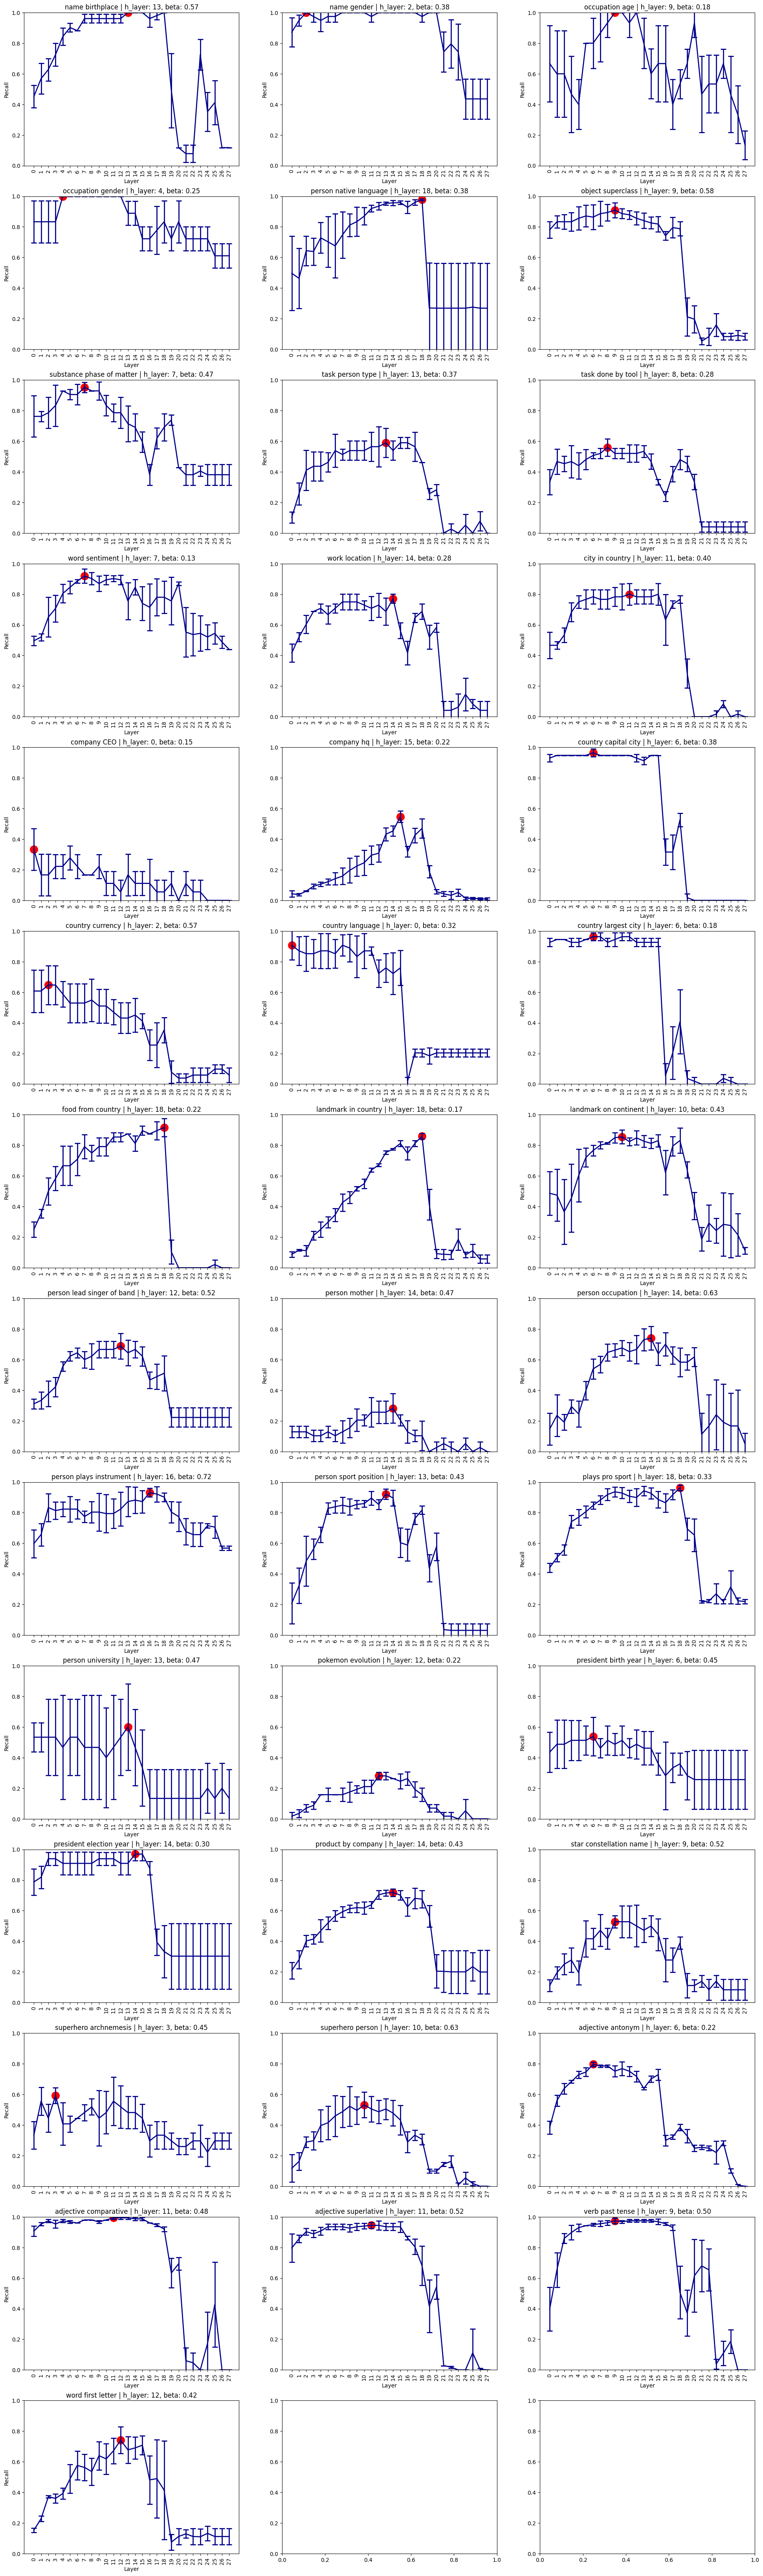

In [9]:
n_subplots = len(filtered_results)
ncols=3
nrows=int(np.ceil(n_subplots/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
if n_subplots == 1:
    axes = [axes]

ax_col, ax_row = 0, 0
for i, (relation_name, relation_result) in enumerate(filtered_results.items()):
    result = parse_results(sweep_results[relation_name])
    plot_layerwise(axes[ax_row][ax_col], relation_result)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
    # break
fig.show()

In [10]:
def plot_betawise(canvas, relation_result, recall_at = 1):
    best_layer = result.best()

    beta_recalls = {}
    for trial in relation_result.trials:
        layer = trial.layers[best_layer.layer]
        for beta in layer.result.betas:
            if beta.beta not in beta_recalls:
                beta_recalls[beta.beta] = []
            beta_recalls[beta.beta].append(beta.recall)
    for beta in beta_recalls:
        beta_recalls[beta] = np.array(beta_recalls[beta]).mean(axis = 0)

    betas = list(beta_recalls.keys())
    recalls = [
        # beta_recalls[beta][recall_at-1]
        beta_recalls[beta].mean() 
        for beta in betas
    ]
    canvas.plot(betas, recalls, color='darkblue', linewidth=2)
    canvas.vlines(best_layer.beta.mean, 0, 1, color="darkred", linewidth=2)

    canvas.set_ylim(0, 1)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel("Recall")
    canvas.set_xticks(betas, [np.round(b, 2) for b in betas], rotation=90)
    canvas.set_title(f"{relation_result.relation_name} | h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}")
    
    return canvas

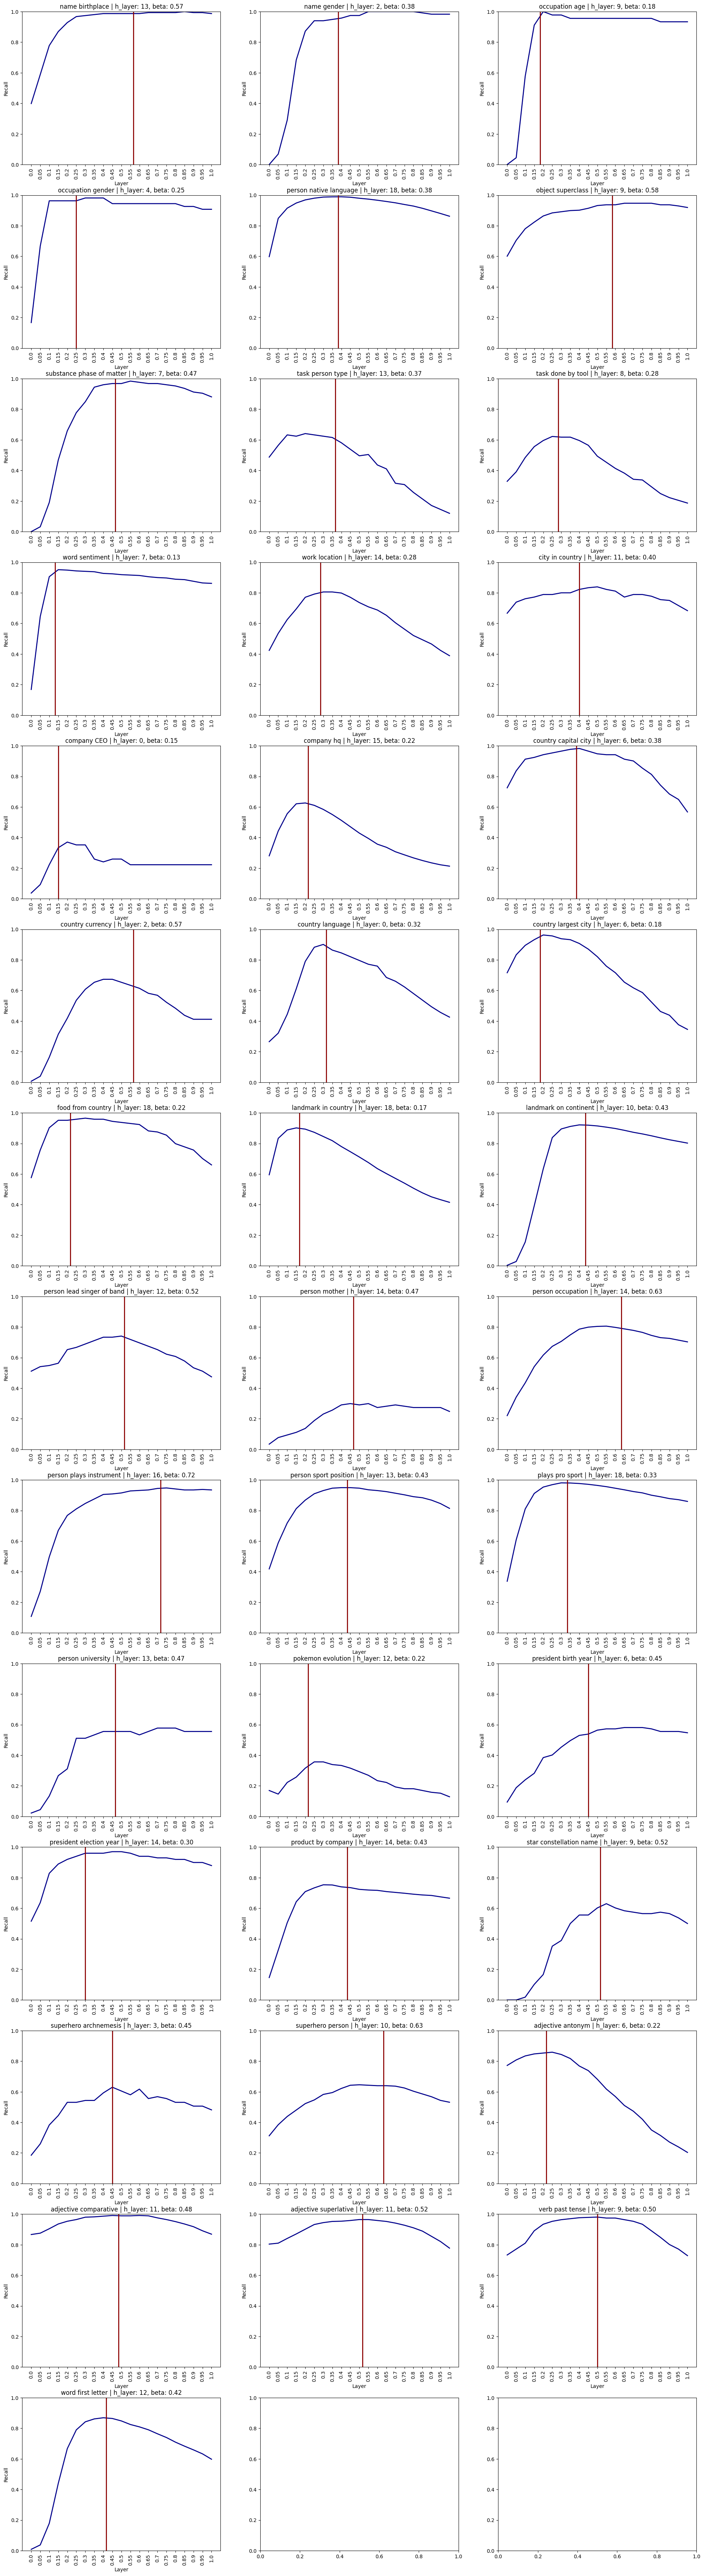

In [11]:
n_subplots = len(filtered_results)
ncols=3
nrows=int(np.ceil(n_subplots/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
if n_subplots == 1:
    axes = [axes]

ax_col, ax_row = 0, 0
for i, (relation_name, relation_result) in enumerate(filtered_results.items()):
    result = parse_results(sweep_results[relation_name])
    plot_betawise(axes[ax_row][ax_col], relation_result)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
fig.show()